In [ ]:
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import scipy.io

all_ssvep = []
all_p300 = []
target_words = []
for i in range(3, 7):
    for j in range(1, 5):
        all_p300.append(
            scipy.io.loadmat(
                "/content/drive/MyDrive/data_project/predicted_P300_"
                + str(i)
                + "_"
                + str(j)
                + ".mat"
            )
        )
        all_ssvep.append(
            scipy.io.loadmat(
                "/content/drive/MyDrive/data_project/predicted_SSVEP_"
                + str(i)
                + "_"
                + str(j)
                + ".mat"
            )
        )
        target_words.append(
            scipy.io.loadmat(
                "/content/drive/MyDrive/data_project/predicted_P300_"
                + str(i)
                + "_"
                + str(j)
                + ".mat"
            )["TestLabels"][0]
        )

In [ ]:
Chars = ["HRT", "IFS", "CN.", "BQV", "OJZ", "XKP", "ALW", "EGD", "MUY"]
Chars = [char.lower() for char in Chars]
Chars_list = [list(x) for x in Chars]
Chars_list[2][2] = "[SPC]"

Chars_p300 = ["HRT", "IFS", "CN.", "BQV", "OJZ", "MUY", "XKP", "ALW", "EGD"]
Chars_p300 = [char.lower() for char in Chars_p300]
Chars_list_p300 = [list(x) for x in Chars_p300]
Chars_list_p300[2][2] = "[SPC]"

In [ ]:
import numpy

count_true = 0
count_total = 0
for i in range(len(all_ssvep)):
    ssvep = all_ssvep[i]
    prob = ssvep["outlabels"]
    true_labels = ssvep["true_labels"].squeeze()
    pred_labels = numpy.argmax(prob, axis=-1) + 1
    count_total += len(true_labels)
    count_true += numpy.sum(true_labels == pred_labels)
print("accuracy of ssvep without model:", count_true / count_total * 100)
print("number of true predictions is", count_true, "out of", count_total)

accuracy of ssvep without model: 61.958997722095674
number of true predictions is 272 out of 439


In [ ]:
count_true = 0
count_total = 0
for i in range(len(all_p300)):
    p300 = all_p300[i]
    prob = p300["out_labels"]
    true_labels = p300["true_labels"].squeeze()
    pred_labels = numpy.argmin(prob, axis=-1) + 1
    count_total += len(true_labels)
    count_true += numpy.sum(true_labels == pred_labels)
print("accuracy of p300 without model:", count_true / count_total * 100)
print("number of true predictions is", count_true, "out of", count_total)

accuracy of p300 without model: 65.37585421412301
number of true predictions is 287 out of 439


In [ ]:
from transformers import AutoModelForSequenceClassification
import string
import torch

vocab = list(string.ascii_lowercase) + ["[UNK]"]
label2id = {vocab[i]: i + 1 for i in range(len(vocab))}
id2label = {i + 1: vocab[i] for i in range(len(vocab))}
model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/models/output/checkpoint-105132",
    problem_type="multi_label_classification",
    num_labels=len(vocab),
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cpu")
if torch.cuda.is_available():
    # Send the model to the GPU
    device = torch.device("cuda")
    model.to(device)

In [ ]:
## simple tokenizer
def encode_word(word):
    word = word.lower()
    tokens = []
    for x in word:
        if x in vocab:
            tokens.append(x)
        else:
            tokens.append("[UNK]")
    return tokens


def my_tokenizer(word):
    tokens = encode_word(word)
    return [label2id[x] for x in tokens]

In [ ]:
import torch
import numpy
from scipy.special import softmax

mapper = numpy.eye(len(vocab))


def split(x):
    y = []
    z = []
    for i in range(1, len(x[0])):
        y.append(x[0][:i])
        z.append(x[0][i])
    return y, z

In [ ]:
def acc_cal_normal(target_words, alpha, all_ssvep, do_softmax=False):
    total_count = 0
    total_true_ml = 0
    total_true_nlp = 0
    total_true_merge = 0
    for i in range(len(all_ssvep)):
        ssvep = all_ssvep[i]
        target_word = target_words[i]
        prob = ssvep["outlabels"]
        true_labels = ssvep["true_labels"].squeeze()
        if do_softmax:
            ssvep_p = softmax(prob, axis=1)
        else:
            ssvep_p = prob

        input = torch.tensor(my_tokenizer(target_word))
        input = input[None, :]
        y, z = split(input)
        for j in range(len(y)):
            inp = y[j][None, :].to(device)

            out = model(input_ids=inp)["logits"]
            probs = torch.nn.functional.softmax(out, dim=-1)
            probs = probs.cpu().detach().numpy()
            dict_out = {
                list(label2id.keys())[i]: probs[0][i]
                for i in range(len(label2id.keys()))
            }
            dict_out["[SPC]"] = 0
            index = [
                (i, k)
                for i, row in enumerate(Chars_list)
                for k, col in enumerate(row)
                if col == id2label[int(z[j])]
            ][0]
            probs_nlp_model = [dict_out[x] for x in Chars_list[index[0]]]
            probs_nlp_model = [x / sum(probs_nlp_model) for x in probs_nlp_model]
            probs_ml_model = list(ssvep_p[j + 1])

            best_nlp = probs_nlp_model.index(max(probs_nlp_model))
            best_ml = probs_ml_model.index(max(probs_ml_model))
            if Chars_list[index[0]][best_ml] == "[SPC]":
                probs_ml_model[2] = -100
                best_ml = probs_ml_model.index(max(probs_ml_model))
            probs_merge = [
                x * alpha + y * (1 - alpha)
                for x, y in zip(probs_nlp_model, probs_ml_model)
            ]
            best_merge = probs_merge.index(max(probs_merge))
            total_count += 1
            if id2label[int(z[j])] == Chars_list[index[0]][best_nlp]:
                total_true_nlp += 1
            if id2label[int(z[j])] == Chars_list[index[0]][best_ml]:
                total_true_ml += 1
            if id2label[int(z[j])] == Chars_list[index[0]][best_merge]:
                total_true_merge += 1
    return total_count, total_true_merge

person = 0 ######################
with softmax CV acc for best alpha: 72.7 ||||and CV acc for alpha = 0 : 64.5 |||| that means the improvment is: 8.2 |||| best alpha is: 0.2
without softmax CV acc for best alpha: 72.7 ||||and CV acc for alpha = 0 : 64.5 |||| that means the improvment is: 8.2 |||| best alpha is: 0.44


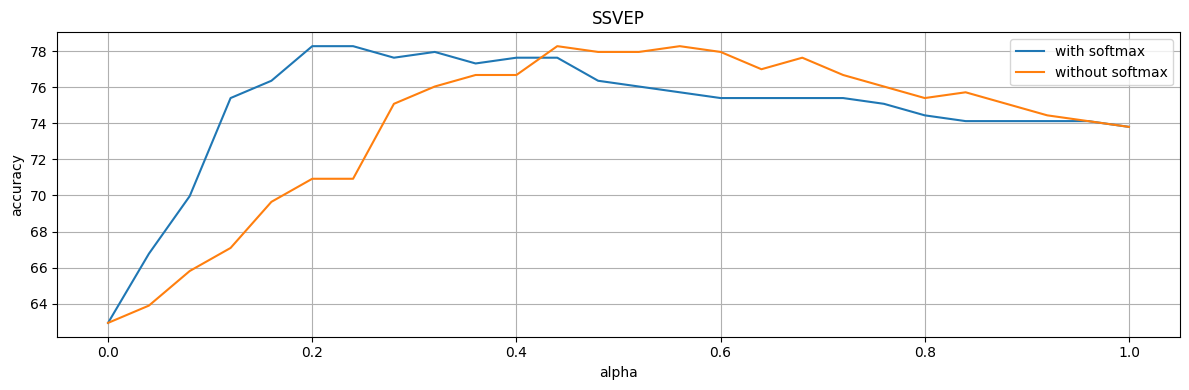

person = 1 ######################
with softmax CV acc for best alpha: 80.5 ||||and CV acc for alpha = 0 : 70.7 |||| that means the improvment is: 9.8 |||| best alpha is: 0.24
without softmax CV acc for best alpha: 79.3 ||||and CV acc for alpha = 0 : 70.7 |||| that means the improvment is: 8.5 |||| best alpha is: 0.48


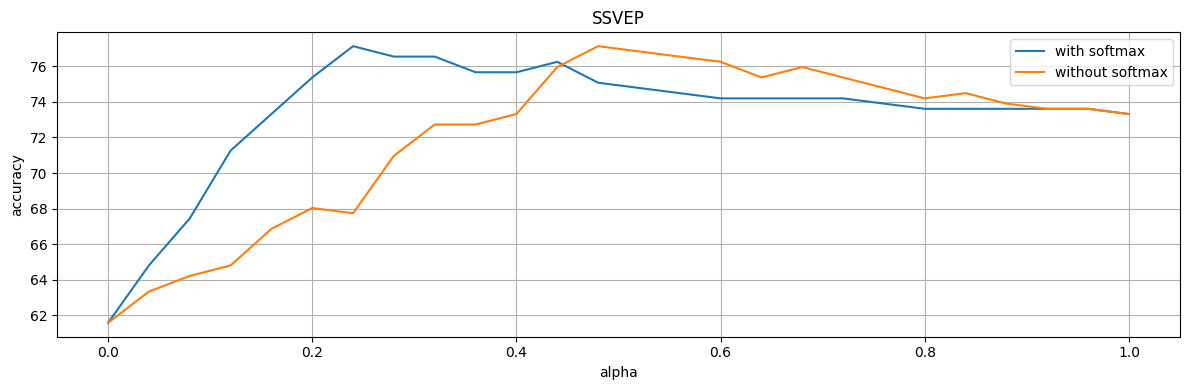

person = 2 ######################
with softmax CV acc for best alpha: 78.8 ||||and CV acc for alpha = 0 : 59.6 |||| that means the improvment is: 19.2 |||| best alpha is: 0.24
without softmax CV acc for best alpha: 78.8 ||||and CV acc for alpha = 0 : 59.6 |||| that means the improvment is: 19.2 |||| best alpha is: 0.48


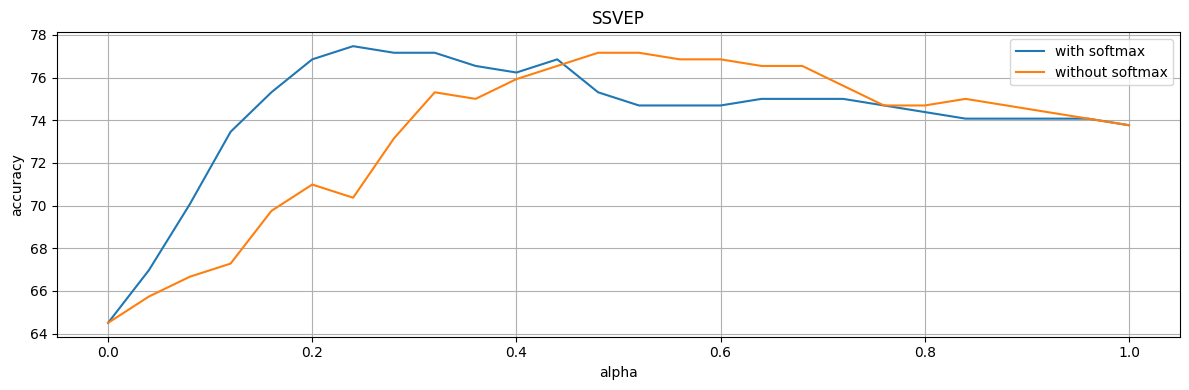

person = 3 ######################
with softmax CV acc for best alpha: 76.5 ||||and CV acc for alpha = 0 : 60.6 |||| that means the improvment is: 15.9 |||| best alpha is: 0.24
without softmax CV acc for best alpha: 75.8 ||||and CV acc for alpha = 0 : 60.6 |||| that means the improvment is: 15.2 |||| best alpha is: 0.52


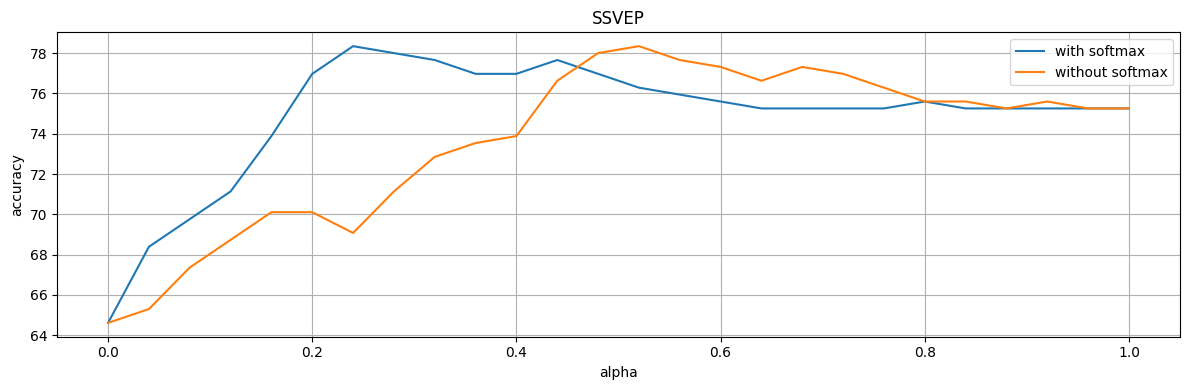

In [ ]:
import matplotlib.pyplot as plt

best_alphas_ssvep = []
diff_alpha = 0.04
range_alpha = numpy.arange(0, 1 + diff_alpha, diff_alpha)
for i in range(4):
    print("person =", i, "######################")
    test_idx = list(range(4 * i, 4 * i + 4))
    all_ssvep_test = [all_ssvep[i] for i in test_idx]
    target_words_test = [target_words[i] for i in test_idx]

    train_idx = [i for i in range(len(all_ssvep)) if i not in test_idx]
    all_ssvep_train = [all_ssvep[i] for i in train_idx]
    target_words_train = [target_words[i] for i in train_idx]

    Acc = []
    Alpha = []
    best_acc = 0
    best_alpha = 0
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))

    for alpha in range_alpha:
        total_count, total_true_merge = acc_cal_normal(
            target_words_train, alpha, all_ssvep_train, True
        )
        acc = total_true_merge / total_count
        Acc.append(acc * 100)
        Alpha.append(alpha)
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha

    best_alphas_ssvep.append(best_alpha)
    axes.plot(Alpha, Acc, label="with softmax")

    total_count, total_true_merge = acc_cal_normal(
        target_words_test, best_alpha, all_ssvep_test, True
    )
    acc_opt = total_true_merge / total_count
    total_count, total_true_merge = acc_cal_normal(
        target_words_test, 0, all_ssvep_test, True
    )
    acc_zero = total_true_merge / total_count
    print(
        "with softmax CV acc for best alpha:",
        round(acc_opt * 100, 1),
        "||||and CV acc for alpha = 0 :",
        round(acc_zero * 100, 1),
        "|||| that means the improvment is:",
        round((acc_opt - acc_zero) * 100, 1),
        "|||| best alpha is:",
        round(best_alpha, 2),
    )
    Acc = []
    Alpha = []
    best_acc = 0
    best_alpha = 0
    for alpha in range_alpha:
        total_count, total_true_merge = acc_cal_normal(
            target_words_train, alpha, all_ssvep_train, False
        )
        acc = total_true_merge / total_count
        Acc.append(acc * 100)
        Alpha.append(alpha)
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
    axes.plot(Alpha, Acc, label="without softmax")
    axes.set_xlabel("alpha")
    axes.set_ylabel("accuracy")
    axes.legend()
    axes.set_title("SSVEP")
    axes.grid(True)

    total_count, total_true_merge = acc_cal_normal(
        target_words_test, best_alpha, all_ssvep_test, False
    )
    acc_opt = total_true_merge / total_count
    total_count, total_true_merge = acc_cal_normal(
        target_words_test, 0, all_ssvep_test, False
    )
    acc_zero = total_true_merge / total_count
    print(
        "without softmax CV acc for best alpha:",
        round(acc_opt * 100, 1),
        "||||and CV acc for alpha = 0 :",
        round(acc_zero * 100, 1),
        "|||| that means the improvment is:",
        round((acc_opt - acc_zero) * 100, 1),
        "|||| best alpha is:",
        round(best_alpha, 2),
    )

    plt.tight_layout()
    plt.show()

In [ ]:
def acc_cal_normal_p300(target_words, alpha, all_p300, do_softmax=False, do_max=True):
    total_count = 0
    total_true_ml = 0
    total_true_nlp = 0
    total_true_merge = 0
    for i in range(len(all_p300)):
        p300 = all_p300[i]
        target_word = target_words[i]
        prob = -p300["out_labels"]
        true_labels = p300["true_labels"].squeeze()
        if do_softmax:
            p300_p = softmax(prob, axis=1)
        else:
            p300_p = prob
        input = torch.tensor(my_tokenizer(target_word))
        input = input[None, :]
        y, z = split(input)
        for j in range(len(y)):
            inp = y[j][None, :].to(device)

            out = model(input_ids=inp)["logits"]
            probs = torch.nn.functional.softmax(out, dim=-1)
            probs = probs.cpu().detach().numpy()
            dict_out = {
                list(label2id.keys())[i]: probs[0][i]
                for i in range(len(label2id.keys()))
            }
            dict_out["[SPC]"] = 0
            index = [
                (i, k)
                for i, row in enumerate(Chars_list_p300)
                for k, col in enumerate(row)
                if col == id2label[int(z[j])]
            ][0]

            if do_max:
                probs_nlp_model = [
                    max(dict_out[x[0]], dict_out[x[1]], dict_out[x[2]])
                    for x in Chars_list_p300
                ]
            else:
                probs_nlp_model = [
                    dict_out[x[0]] + dict_out[x[1]] + dict_out[x[2]]
                    for x in Chars_list_p300
                ]

            probs_nlp_model = [x / sum(probs_nlp_model) for x in probs_nlp_model]
            probs_ml_model = list(p300_p[j + 1])
            best_nlp = probs_nlp_model.index(max(probs_nlp_model))
            best_ml = probs_ml_model.index(max(probs_ml_model))
            probs_merge = [
                x * alpha + y * (1 - alpha)
                for x, y in zip(probs_nlp_model, probs_ml_model)
            ]
            best_merge = probs_merge.index(max(probs_merge))

            total_count += 1
            if id2label[int(z[j])] in Chars_list_p300[best_nlp]:
                total_true_nlp += 1
            if id2label[int(z[j])] in Chars_list_p300[best_ml]:
                total_true_ml += 1
            if id2label[int(z[j])] in Chars_list_p300[best_merge]:
                total_true_merge += 1
    return total_count, total_true_merge

person = 0 ######################
with max and sofmax CV acc for best alpha: 60.0 ||||and CV acc for alpha = 0 : 51.8 |||| that means the improvment is: 8.2 |||| best alpha is: 0.24
with max and without sofmax CV acc for best alpha: 61.8 ||||and CV acc for alpha = 0 : 51.8 |||| that means the improvment is: 10.0 |||| best alpha is: 0.72
with average and sofmax CV acc for best alpha: 60.0 ||||and CV acc for alpha = 0 : 51.8 |||| that means the improvment is: 8.2 |||| best alpha is: 0.28
with average and without softmax CV acc for best alpha: 59.1 ||||and CV acc for alpha = 0 : 51.8 |||| that means the improvment is: 7.3 |||| best alpha is: 0.6


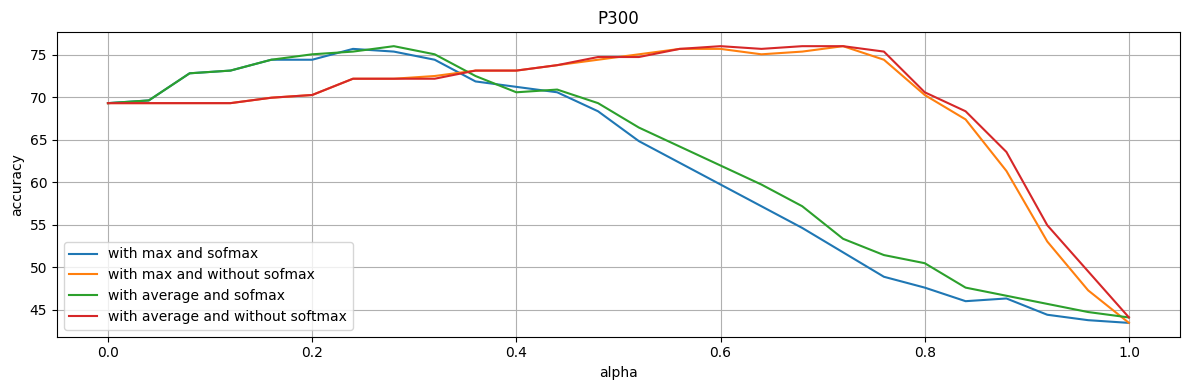

person = 1 ######################
with max and sofmax CV acc for best alpha: 84.1 ||||and CV acc for alpha = 0 : 75.6 |||| that means the improvment is: 8.5 |||| best alpha is: 0.24
with max and without sofmax CV acc for best alpha: 80.5 ||||and CV acc for alpha = 0 : 75.6 |||| that means the improvment is: 4.9 |||| best alpha is: 0.72
with average and sofmax CV acc for best alpha: 84.1 ||||and CV acc for alpha = 0 : 75.6 |||| that means the improvment is: 8.5 |||| best alpha is: 0.28
with average and without softmax CV acc for best alpha: 80.5 ||||and CV acc for alpha = 0 : 75.6 |||| that means the improvment is: 4.9 |||| best alpha is: 0.72


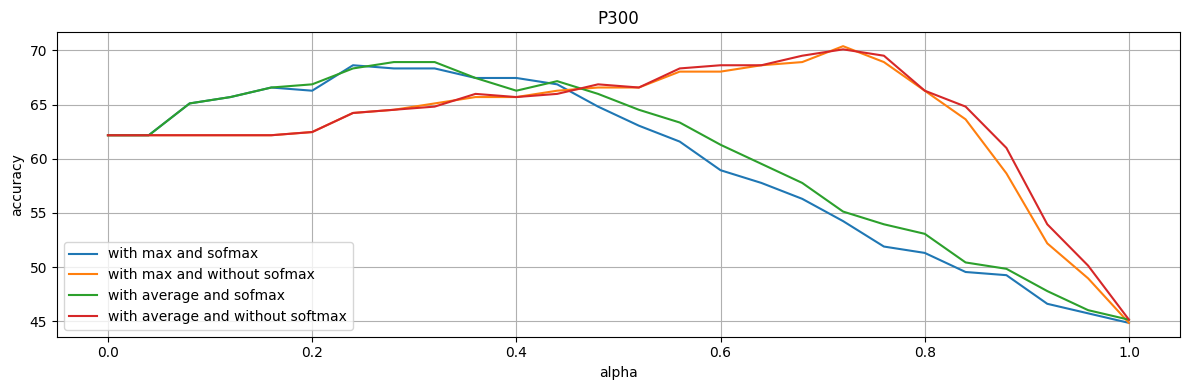

person = 2 ######################
with max and sofmax CV acc for best alpha: 57.6 ||||and CV acc for alpha = 0 : 52.5 |||| that means the improvment is: 5.1 |||| best alpha is: 0.24
with max and without sofmax CV acc for best alpha: 62.6 ||||and CV acc for alpha = 0 : 52.5 |||| that means the improvment is: 10.1 |||| best alpha is: 0.72
with average and sofmax CV acc for best alpha: 57.6 ||||and CV acc for alpha = 0 : 52.5 |||| that means the improvment is: 5.1 |||| best alpha is: 0.24
with average and without softmax CV acc for best alpha: 58.6 ||||and CV acc for alpha = 0 : 52.5 |||| that means the improvment is: 6.1 |||| best alpha is: 0.6


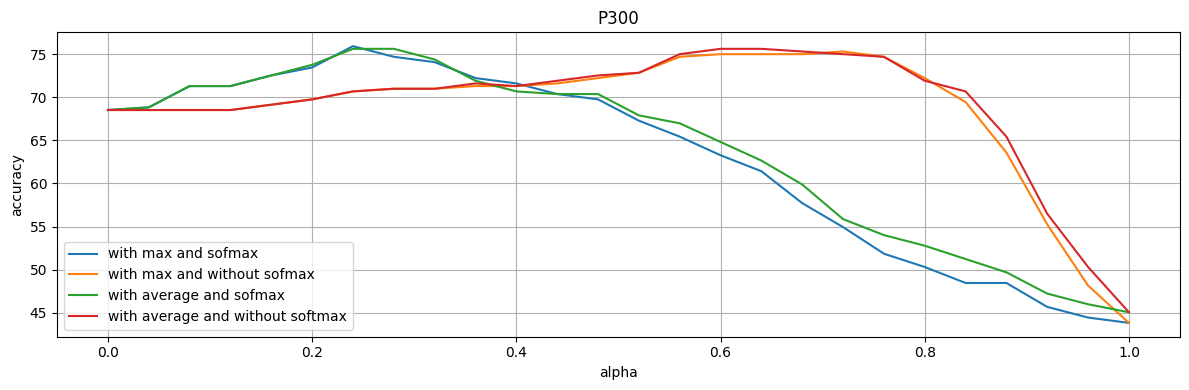

person = 3 ######################
with max and sofmax CV acc for best alpha: 84.1 ||||and CV acc for alpha = 0 : 78.0 |||| that means the improvment is: 6.1 |||| best alpha is: 0.24
with max and without sofmax CV acc for best alpha: 83.3 ||||and CV acc for alpha = 0 : 78.0 |||| that means the improvment is: 5.3 |||| best alpha is: 0.72
with average and sofmax CV acc for best alpha: 83.3 ||||and CV acc for alpha = 0 : 78.0 |||| that means the improvment is: 5.3 |||| best alpha is: 0.28
with average and without softmax CV acc for best alpha: 83.3 ||||and CV acc for alpha = 0 : 78.0 |||| that means the improvment is: 5.3 |||| best alpha is: 0.72


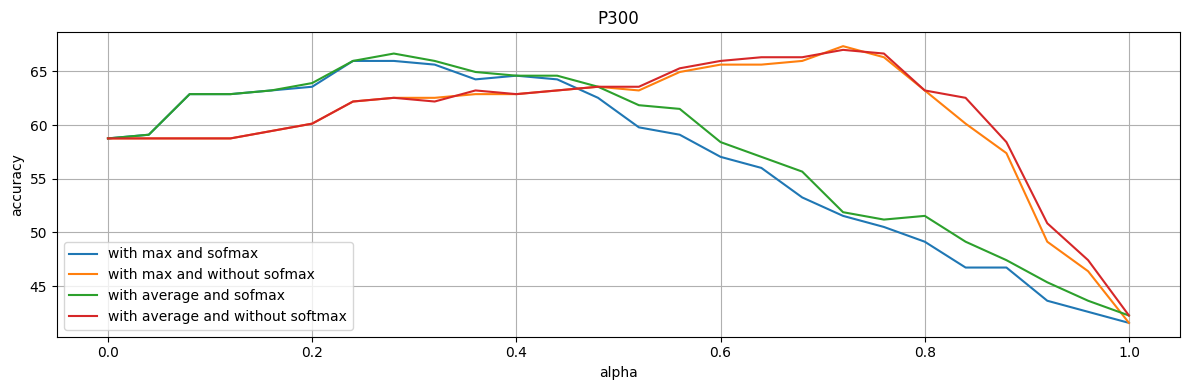

In [ ]:
best_alphas_p300 = []
best_methods = []
methods = (True, True)
for i in range(4):
    print("person =", i, "######################")
    best_acc_methods = 0
    best_alpha_methods = 0
    test_idx = list(range(4 * i, 4 * i + 4))
    all_p300_test = [all_p300[i] for i in test_idx]
    target_words_test = [target_words[i] for i in test_idx]

    train_idx = [i for i in range(len(all_ssvep)) if i not in test_idx]
    all_p300_train = [all_p300[i] for i in train_idx]
    target_words_train = [target_words[i] for i in train_idx]

    Acc = []
    Alpha = []
    best_acc = 0
    best_alpha = 0
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    for alpha in range_alpha:
        total_count, total_true_merge = acc_cal_normal_p300(
            target_words_train, alpha, all_p300_train, True, True
        )
        acc = total_true_merge / total_count
        # print("for alpha:",round(alpha,2),"the accuracy is:",round(acc*100,2))
        Acc.append(acc * 100)
        Alpha.append(alpha)
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
    if best_acc_methods < best_acc:
        best_acc_methods = best_acc
        methods = (True, True)
        best_alpha_methods = best_alpha

    axes.plot(Alpha, Acc, label="with max and sofmax")

    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, best_alpha, all_p300_test, True, True
    )
    acc_opt = total_true_merge / total_count
    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, 0, all_p300_test, True, True
    )
    acc_zero = total_true_merge / total_count

    print(
        "with max and sofmax CV acc for best alpha:",
        round(acc_opt * 100, 1),
        "||||and CV acc for alpha = 0 :",
        round(acc_zero * 100, 1),
        "|||| that means the improvment is:",
        round((acc_opt - acc_zero) * 100, 1),
        "|||| best alpha is:",
        round(best_alpha, 2),
    )

    Acc = []
    Alpha = []
    best_acc = 0
    best_alpha = 0
    for alpha in range_alpha:
        total_count, total_true_merge = acc_cal_normal_p300(
            target_words_train, alpha, all_p300_train, False, True
        )
        acc = total_true_merge / total_count
        # print("for alpha:",round(alpha,2),"the accuracy is:",round(acc*100,2))
        Acc.append(acc * 100)
        Alpha.append(alpha)
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
    if best_acc_methods < best_acc:
        best_acc_methods = best_acc
        methods = (False, True)
        best_alpha_methods = best_alpha
    axes.plot(Alpha, Acc, label="with max and without sofmax")

    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, best_alpha, all_p300_test, False, True
    )
    acc_opt = total_true_merge / total_count
    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, 0, all_p300_test, False, True
    )
    acc_zero = total_true_merge / total_count
    print(
        "with max and without sofmax CV acc for best alpha:",
        round(acc_opt * 100, 1),
        "||||and CV acc for alpha = 0 :",
        round(acc_zero * 100, 1),
        "|||| that means the improvment is:",
        round((acc_opt - acc_zero) * 100, 1),
        "|||| best alpha is:",
        round(best_alpha, 2),
    )

    Acc = []
    Alpha = []
    best_acc = 0
    best_alpha = 0
    for alpha in range_alpha:
        total_count, total_true_merge = acc_cal_normal_p300(
            target_words_train, alpha, all_p300_train, True, False
        )
        acc = total_true_merge / total_count
        # print("for alpha:",round(alpha,2),"the accuracy is:",round(acc*100,2))
        Acc.append(acc * 100)
        Alpha.append(alpha)
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
    if best_acc_methods < best_acc:
        best_acc_methods = best_acc
        methods = (True, False)
        best_alpha_methods = best_alpha
    axes.plot(Alpha, Acc, label="with average and sofmax")

    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, best_alpha, all_p300_test, True, False
    )
    acc_opt = total_true_merge / total_count
    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, 0, all_p300_test, True, False
    )
    acc_zero = total_true_merge / total_count
    print(
        "with average and sofmax CV acc for best alpha:",
        round(acc_opt * 100, 1),
        "||||and CV acc for alpha = 0 :",
        round(acc_zero * 100, 1),
        "|||| that means the improvment is:",
        round((acc_opt - acc_zero) * 100, 1),
        "|||| best alpha is:",
        round(best_alpha, 2),
    )

    Acc = []
    Alpha = []
    best_acc = 0
    best_alpha = 0
    for alpha in range_alpha:
        total_count, total_true_merge = acc_cal_normal_p300(
            target_words_train, alpha, all_p300_train, False, False
        )
        acc = total_true_merge / total_count
        # print("for alpha:",round(alpha,2),"the accuracy is:",round(acc*100,2))
        Acc.append(acc * 100)
        Alpha.append(alpha)
        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
    if best_acc_methods < best_acc:
        best_acc_methods = best_acc
        methods = (False, False)
        best_alpha_methods = best_alpha

    best_alphas_p300.append(best_alpha_methods)
    best_methods.append(methods)
    axes.plot(Alpha, Acc, label="with average and without softmax")
    axes.set_xlabel("alpha")
    axes.set_ylabel("accuracy")
    axes.legend()
    axes.set_title("P300")
    axes.grid(True)

    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, best_alpha, all_p300_test, False, False
    )
    acc_opt = total_true_merge / total_count
    total_count, total_true_merge = acc_cal_normal_p300(
        target_words_test, 0, all_p300_test, False, False
    )
    acc_zero = total_true_merge / total_count
    print(
        "with average and without softmax CV acc for best alpha:",
        round(acc_opt * 100, 1),
        "||||and CV acc for alpha = 0 :",
        round(acc_zero * 100, 1),
        "|||| that means the improvment is:",
        round((acc_opt - acc_zero) * 100, 1),
        "|||| best alpha is:",
        round(best_alpha, 2),
    )
    # print("improvement for true input is ",best_acc-Acc[0],"percentage and best acc is ",best_acc)

    plt.tight_layout()
    plt.show()

In [ ]:
best_alphas_p300
best_alphas_ssvep